In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import scirpy as ir
import anndata as ann

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

sc.settings.verbosity = 3


In [2]:
sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

Paths to preprocessed data at different stages.

In [10]:
path_base = '../data/10x_CD8TC/'
path_merged = path_base + 'merged_tcr_10x.h5ad'
path_filtered = path_base + 'filtered_tcr_10x.h5ad'
path_normalized = path_base + 'scran_tcr_10x.h5ad'
path_highlyvar = path_base + 'highly_var_5000.h5ad'

## Merge Files

The 10x VDJ dataset consists of CD8+ T cells from for donor. First, transcriptome data is merged with tcr information. In a second step, the data is fused over all donors. In the third step, the measured binding affinity is merged.

In [4]:
adatas = []
batch_names = []
for i in range(1, 5):
    # Transcriptome data
    file_name = path_base + f'patient_{i}/vdj_v1_hs_aggregated_donor{i}_filtered_feature_bc_matrix.h5'
    adata_tmp = sc.read_10x_h5(file_name)
    
    # TCR data
    path_anno = path_base + f'patient_{i}/vdj_v1_hs_aggregated_donor{i}_all_contig_annotations.csv'
    anno_tcr = ir.io.read_10x_vdj(path_anno)    
    ir.pp.merge_with_ir(adata_tmp, anno_tcr)
        
    # Binding data
    path_binding = path_base + f'patient_{i}/vdj_v1_hs_aggregated_donor{i}_binarized_matrix.csv'
    binarized_matrix = pd.read_csv(path_binding, sep=',', header=0)

    for k in binarized_matrix.columns:
        adata_tmp.obs[k] = None
        adata_tmp.obs.loc[binarized_matrix['barcode'].values, k] = binarized_matrix[k].values
    
    adata_tmp.var_names_make_unique()
    adatas.append(adata_tmp)
    batch_names.append(f'donor_{i}')
    
adata = adatas[0].concatenate(adatas[1:], batch_key='donor', batch_categories=batch_names)
sc.write(adata=adata, filename=path_merged)

reading ../data/10x_CD8TC/patient_1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.h5
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 (0:00:02)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'IR_VJ_1_cdr3' as categorical
... storing 'IR_VJ_2_cdr3' as categorical
... storing 'IR_VDJ_1_cdr3' as categorical
... storing 'IR_VDJ_2_cdr3' as categorical
... storing 'IR_VJ_1_cdr3_nt' as categorical
... storing 'IR_VJ_2_cdr3_nt' as categorical
... storing 'IR_VDJ_1_cdr3_nt' as categorical
... storing 'IR_VDJ_2_cdr3_nt' as categorical
... storing 'IR_VJ_1_junction_ins' as categorical
... storing 'IR_VJ_2_junction_ins' as categorical
... storing 'IR_VDJ_1_junction_ins' as categorical
... storing 'IR_VDJ_2_junction_ins' as categorical
... storing 'multi_chain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
reading ../data/10x_CD8TC/patient_2/vdj_v1_hs_aggregate

... storing 'A0201_SLLMWITQV_NY-ESO-1_Cancer_binder' as categorical
... storing 'A0201_KVAELVHFL_MAGE-A3_Cancer_binder' as categorical
... storing 'A0201_KVLEYVIKV_MAGE-A1_Cancer_binder' as categorical
... storing 'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase_binder' as categorical
... storing 'A0201_LLDFVRFMGV_EBNA-3B_EBV_binder' as categorical
... storing 'A0201_LLMGTLGIVC_HPV-16E7_82-91_binder' as categorical
... storing 'A0201_CLGGLLTMV_LMP-2A_EBV_binder' as categorical
... storing 'A0201_YLLEMLWRL_LMP1_EBV_binder' as categorical
... storing 'A0201_FLYALALLL_LMP2A_EBV_binder' as categorical
... storing 'A0201_GILGFVFTL_Flu-MP_Influenza_binder' as categorical
... storing 'A0201_GLCTLVAML_BMLF1_EBV_binder' as categorical
... storing 'A0201_NLVPMVATV_pp65_CMV_binder' as categorical
... storing 'A0201_ILKEPVHGV_RT_HIV_binder' as categorical
... storing 'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2_binder' as categorical
... storing 'A2402_CYTWNQMNL_WT1-(235-243)236M_Y_binder' as categorical
... st

In [6]:
count_irs = sum([1 for x in adata.obs['has_ir'] if x=='True'])
print(f'Total Count: {len(adata.obs)}')
print(f'With IR-Info: {count_irs}')

Total Count: 237883
With IR-Info: 189512


In [7]:
# 237883
adata.obs['donor'].value_counts()

donor_2    91921
donor_1    55206
donor_3    54137
donor_4    36619
Name: donor, dtype: int64

# Qualitiy control

Load data and calculate the amount of counts, genes and fraction of mitochondrial genes.

In [8]:
adata = sc.read(path_merged)
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]  # TODO MTX?
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:, mt_gene_index].sum(1) / adata.X.sum(1)

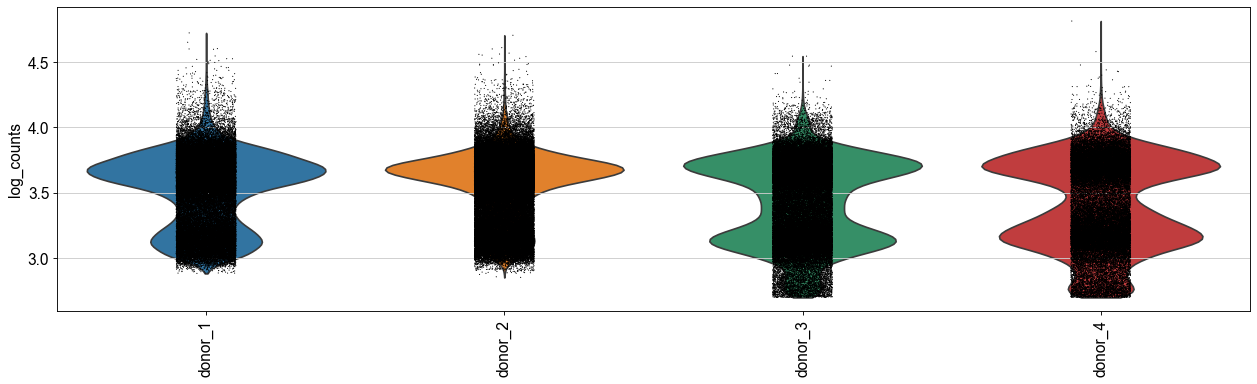

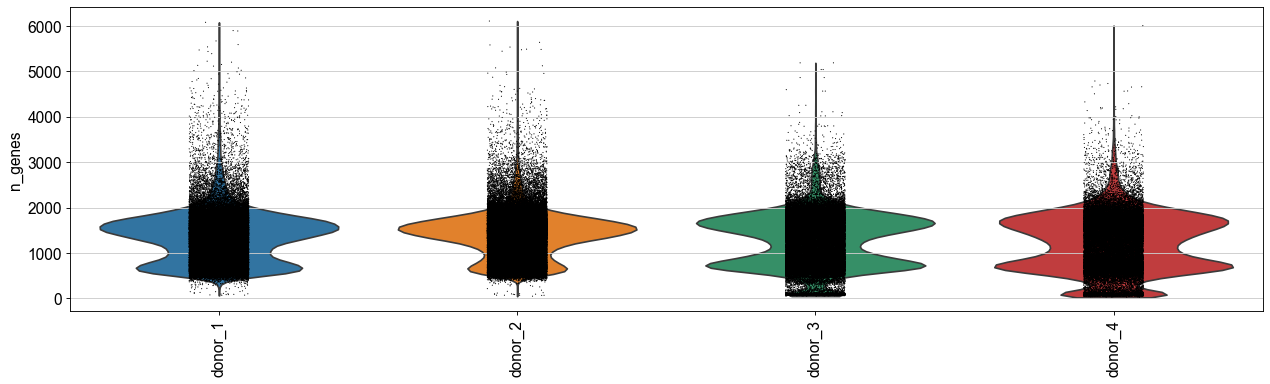

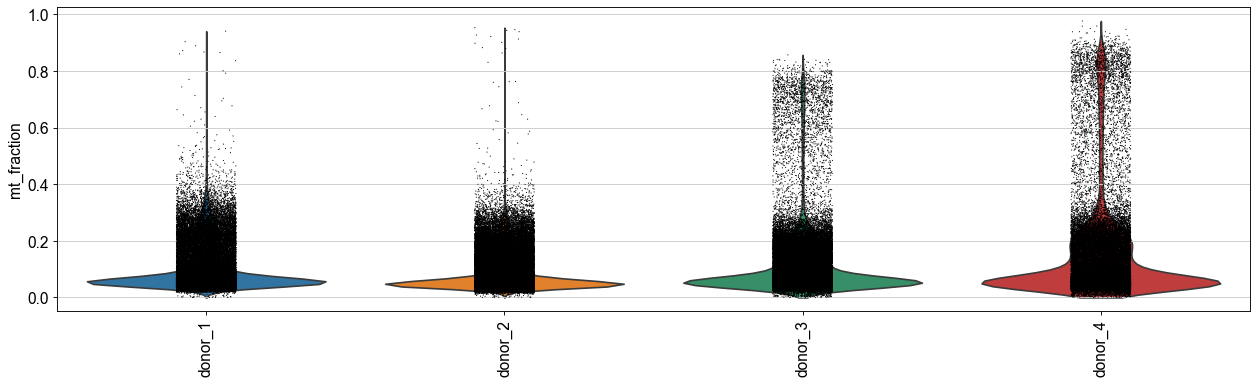

In [9]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata, ['log_counts'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_fraction'], groupby='donor', size=1, log=False, rotation=90)

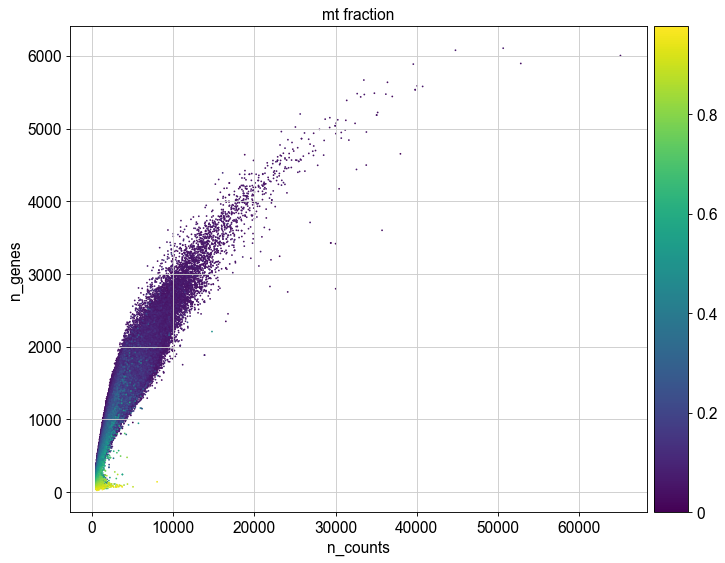

In [10]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)

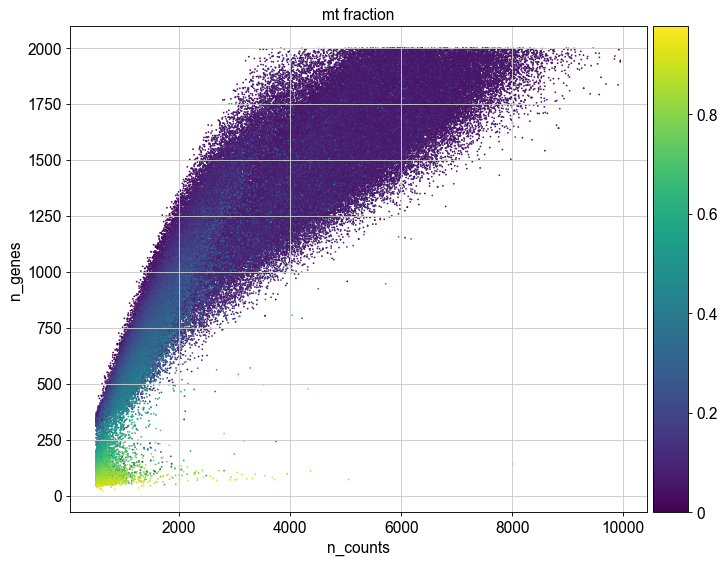

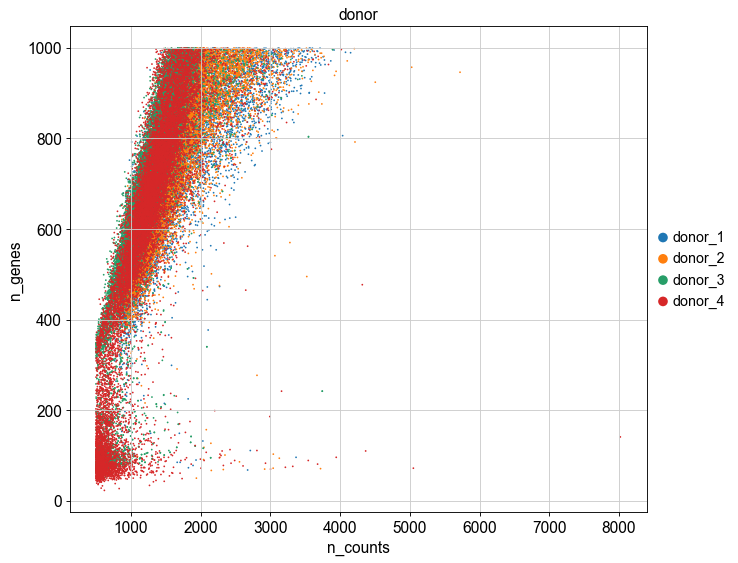

In [11]:
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<2000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<1000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='donor', size=10, show=False)

## Cell Filtering

Filter cells by the following indicators:
- fraction of mitochondrial genes (max)
- gene count (min, max)
- gene count (max)

Filter genes by:
- amount of cells representing this gene (min)


Mitochondrial filter: The fraction of mt genes to all genes is high for cell with membrane leakage.

In [12]:
adata_tmp = adata.copy()
print(f'Total number of cells: {adata_tmp.n_obs}')
high_mt = adata_tmp.obs['mt_fraction'] < 0.2  #todo why this value
adata_tmp = adata_tmp[high_mt]
print(f'Number of cells after MT filter: {adata_tmp.n_obs}')

Total number of cells: 237883
Number of cells after MT filter: 208593


Gene-Count Filter between 1000 and 10.000

In [15]:
low_count = adata_tmp.obs['n_counts'] > 1000
adata_tmp = adata_tmp[low_count]
print(f'Number of cells after minimum count filter: {adata_tmp.n_obs}')

sc.pp.filter_cells(adata_tmp, max_counts=10000)
print(f'Number of cells after maximum filter: {adata_tmp.n_obs}')

Number of cells after minimum count filter: 201428


Trying to set attribute `.obs` of view, copying.


Number of cells after maximum filter: 201428


Gene-Count Filter: filter out cells with low gene count < 500

In [16]:
low_genes = adata_tmp.obs['n_genes'] > 500
adata_tmp = adata_tmp[low_genes]
print(f'Number of cells after minimum gene filter: {adata_tmp.n_obs}')

Number of cells after minimum gene filter: 201235


Gene-Filter: filter out genes that are represented in less than 10 cells

In [17]:
sc.pp.filter_genes(adata_tmp, min_cells=10)
print(f'Number of cells after gene filter: {adata_tmp.n_vars}')

filtered out 13831 genes that are detected in less than 10 cells
Trying to set attribute `.var` of view, copying.


Number of cells after gene filter: 19707


## Doublet detection

In droplet based methods multiple cells might be present in a drop. The droplet score is evaluated by Scrublet.

In [18]:
import scrublet as scr
import scipy.io
import time

In [19]:
adata_tmp.obs['doublet_score'] = np.zeros(adata_tmp.shape[0])
adata_tmp.obs['doublet'] = np.zeros(adata_tmp.shape[0])

In [20]:
# filtering / preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters
expected_doublet_rate = 0.02
sim_doublet_ratio = 3
n_neighbors = 15

for batch in enumerate(adata_tmp.obs['donor'].cat.categories):
    print(batch)
    t0 = time.time()
    idx = np.flatnonzero(adata_tmp.obs['donor']==batch[1])
    scrub = scr.Scrublet(counts_matrix = adata_tmp[idx, :].X,
                        n_neighbors = n_neighbors,
                        sim_doublet_ratio = sim_doublet_ratio,
                        expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts = min_counts,
                                                              min_cells = min_cells,
                                                              n_prin_comps = n_pc,
                                                              use_approx_neighbors = True,
                                                              get_doublet_neighbor_parents = False)
    adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores
    adata_tmp.obs['doublet'].iloc[idx] = predicted_doublets
    t1 = time.time()
    print('Elapsed time: {:.1f} seconds'.format(t1-t0))

(0, 'donor_1')
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 44.8%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.8%
Elapsed time: 59.7 seconds
Elapsed time: 61.4 seconds
(1, 'donor_2')


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 34.7%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 6.1%
Elapsed time: 110.8 seconds
Elapsed time: 114.2 seconds
(2, 'donor_3')


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.15
Detected doublet rate = 1.6%
Estimated detectable doublet fraction = 42.6%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.9%
Elapsed time: 61.3 seconds
Elapsed time: 63.5 seconds
(3, 'donor_4')


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 45.5%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.8%
Elapsed time: 33.2 seconds
Elapsed time: 34.4 seconds


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='doublet_score'>

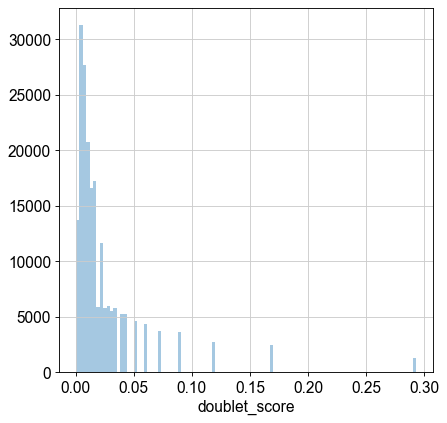

In [21]:
rcParams['figure.figsize'] = (6, 6)
sb.distplot(adata_tmp.obs['doublet_score'], bins=100, kde=False)

... storing 'doublet' as categorical


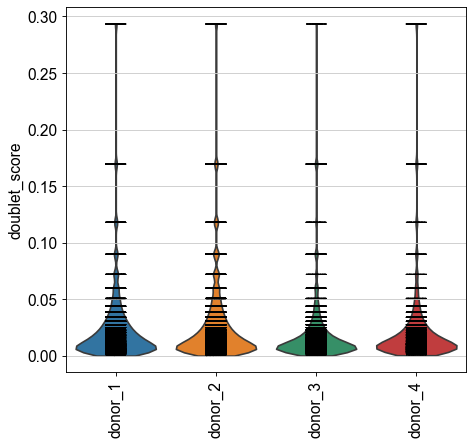

In [22]:
sc.pl.violin(adata_tmp, ['doublet_score'], groupby='donor', size=1, log=False, rotation=90)

In [23]:
thr = 0.05
idx_filter = adata_tmp.obs['doublet_score'] <= thr

adata_tmp = adata_tmp[idx_filter].copy()
print(f'Number of cells after double filter: {adata_tmp.n_obs}')

Number of cells after double filter: 178356


## QC after filtering

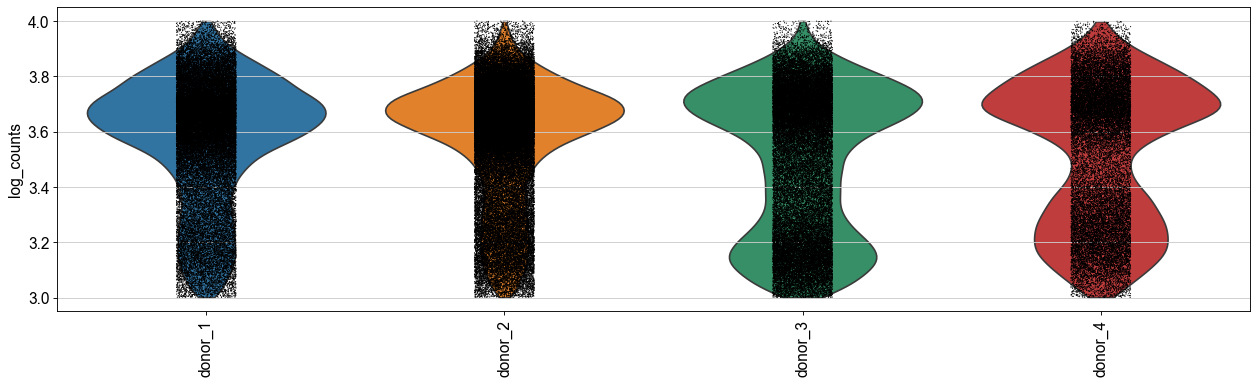

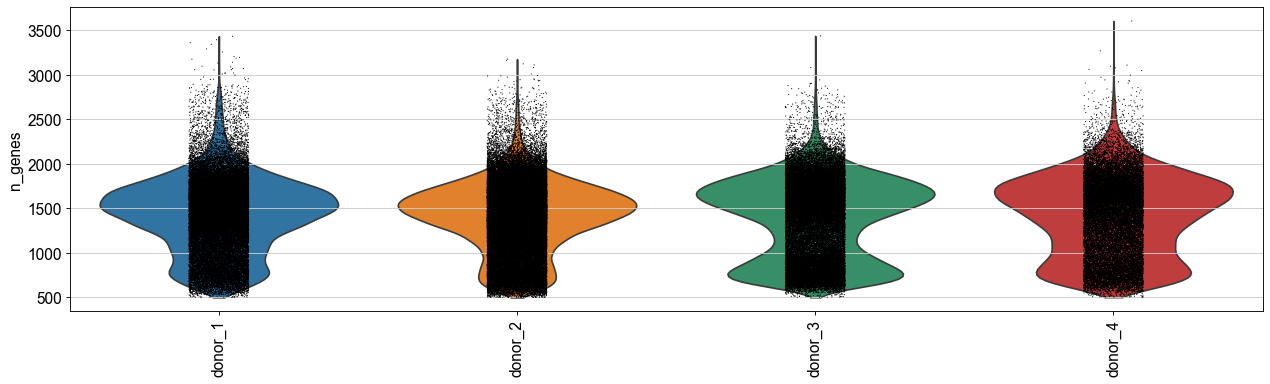

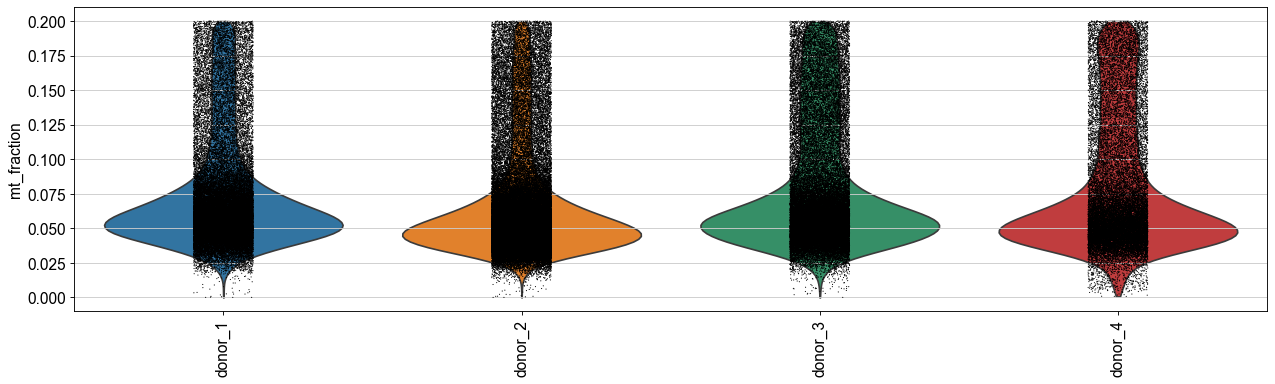

In [24]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata_tmp, ['log_counts'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata_tmp, ['n_genes'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata_tmp, ['mt_fraction'], groupby='donor', size=1, log=False, rotation=90)

In [25]:
df = adata_tmp.obs[['n_genes', 'n_counts', 'donor']]
df_all = pd.DataFrame(df.groupby(by='donor')['n_genes'].apply(np.mean).values, 
                      index=df.groupby(by='donor')['n_genes'].apply(np.mean).index, 
                      columns=['mean_genes'])

df_all['median_genes'] = df.groupby(by='donor')['n_genes'].apply(np.median).values
df_all['mean_counts'] = df.groupby(by='donor')['n_counts'].apply(np.mean).values
df_all['median_counts'] = df.groupby(by='donor')['n_counts'].apply(np.median).values
df_all

,mean_genes,median_genes,mean_counts,median_counts
donor,,,,
donor_1,1428.021586,1472.0,4243.862305,4265.0
donor_2,1409.451561,1462.0,4178.098633,4335.0
donor_3,1384.667215,1484.0,3716.393799,3774.0
donor_4,1412.311165,1474.0,3916.043457,4040.0


## Visualization


In [26]:
sc.pp.normalize_total(adata_tmp, target_sum=1e4)  # target sum? 
sc.pp.log1p(adata_tmp)

normalizing counts per cell
    finished (0:00:01)


In [27]:
sc.tl.pca(adata_tmp, svd_solver='arpack')
sc.pp.neighbors(adata_tmp)

computing PCA
    with n_comps=50
    finished (0:01:35)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:33)


In [28]:
sc.tl.louvain(adata_tmp, resolution=0.5)
sc.tl.umap(adata_tmp)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:01:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:16)


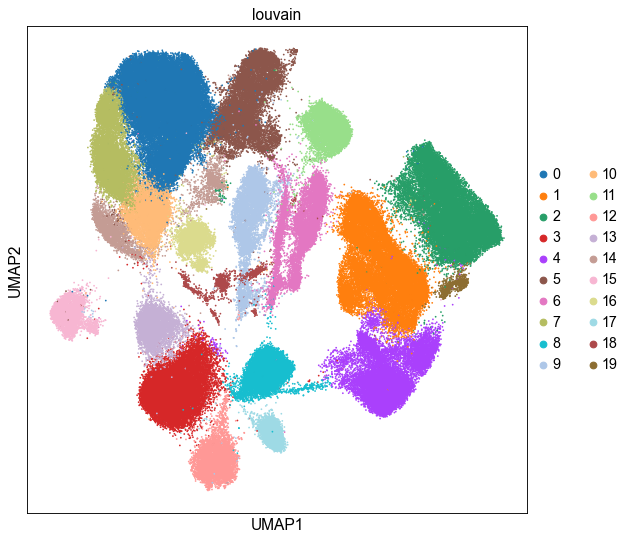

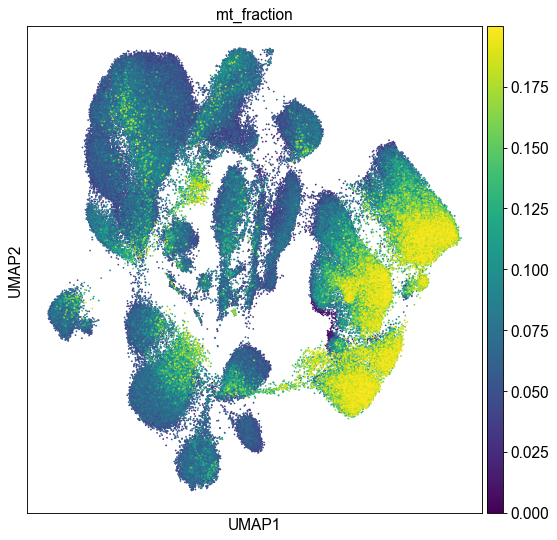

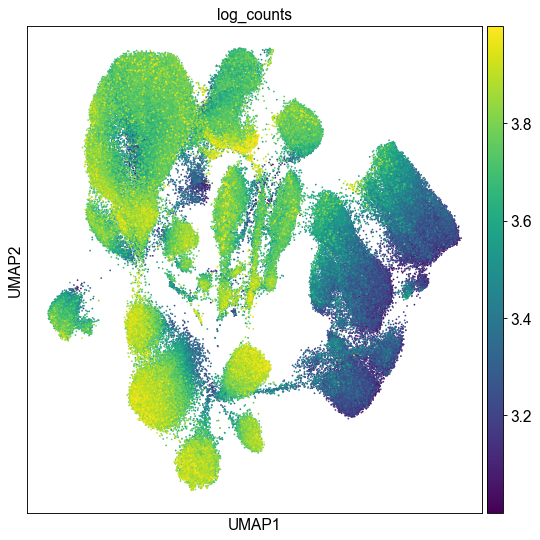

In [29]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.umap(adata_tmp, color='louvain', size=10)
sc.pl.umap(adata_tmp, color='mt_fraction', size=10)
sc.pl.umap(adata_tmp, color='log_counts', size=10)

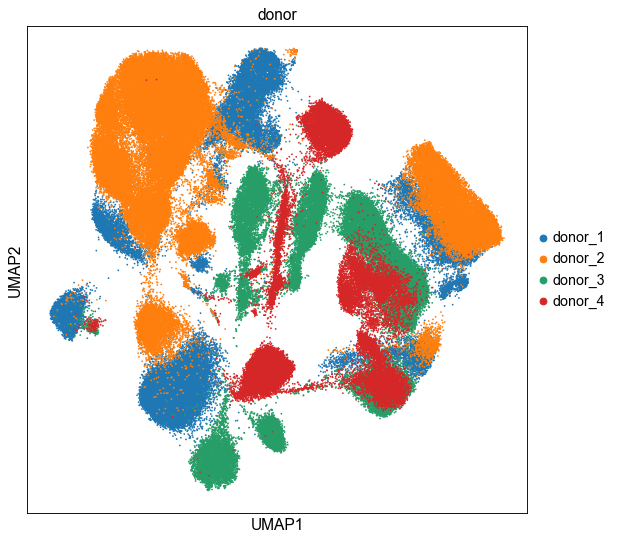

In [30]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.umap(adata_tmp, color='donor', size=10)

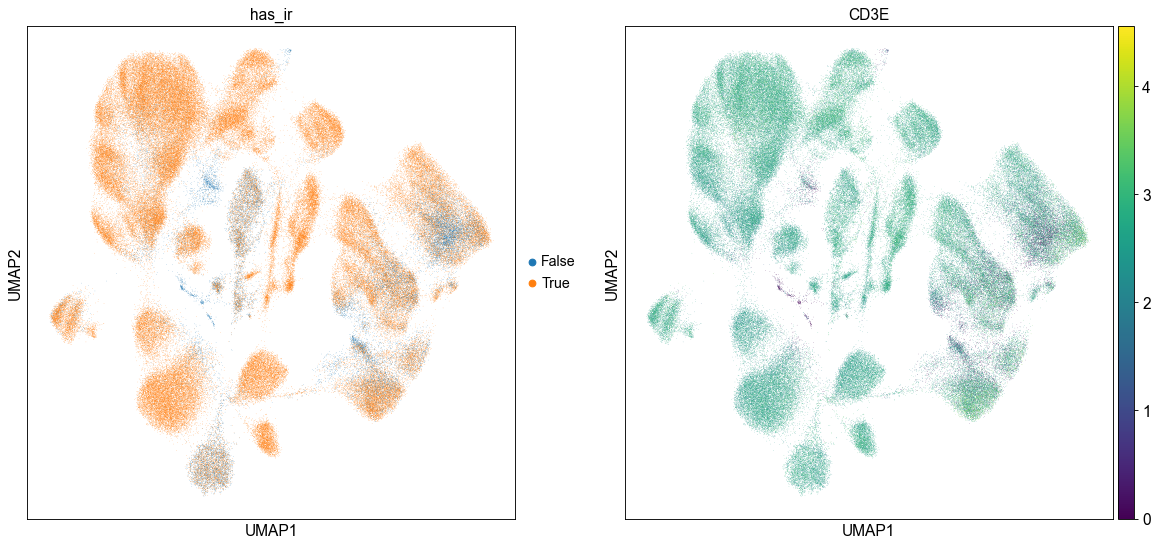

In [31]:
sc.pl.umap(adata_tmp, color=["has_ir", "CD3E"])

In [32]:
sc.write(adata=adata_tmp, filename=path_filtered)

## Highly variable Gens

In [5]:
adata_tmp = sc.read(path_filtered)

In [6]:
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=5000, batch_key='donor')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [12]:
sc.write(adata=adata_tmp, filename=path_highlyvar)

In [16]:
adata_tmp.obs

,IR_VJ_1_locus,IR_VJ_2_locus,IR_VDJ_1_locus,IR_VDJ_2_locus,IR_VJ_1_cdr3,IR_VJ_2_cdr3,IR_VDJ_1_cdr3,IR_VDJ_2_cdr3,IR_VJ_1_cdr3_nt,IR_VJ_2_cdr3_nt,...,A2402_AYSSAGASI_NC_binder,B0702_GPAESAAGL_NC_binder,NR(B0801)_AAKGRGAAL_NC_binder,n_counts,log_counts,n_genes,mt_fraction,doublet_score,doublet,louvain
AAACGGGAGAAGATTC-1-donor_1,TRA,NaN,TRB,NaN,CAMREGSNDMRF,None,CASSIKGPFRTEAFF,None,TGTGCAATGAGAGAGGGCTCGAATGACATGCGCTTT,None,...,False,False,False,5013.0,3.700098,1872,0.044285,0.019183,False,5
AAACGGGTCGGACAAG-1-donor_1,TRA,NaN,TRB,NaN,CAREHMDSNYQLIW,None,CASSQLGRGDNEQFF,None,TGTGCTCGGGAGCACATGGATAGCAACTATCAGTTAATCTGG,None,...,False,False,False,3827.0,3.582859,1512,0.066632,0.002166,False,5
AAAGATGGTACAGACG-1-donor_1,TRA,NaN,TRB,NaN,CAALYNFNKFYF,None,CSARGLTADKDNYEQYF,None,TGTGCCGCGCTCTACAACTTCAACAAATTTTACTTT,None,...,False,False,False,7092.0,3.850769,1912,0.047800,0.043902,False,3
AAAGTAGAGACGCTTT-1-donor_1,TRA,NaN,TRB,NaN,CAVIVWGNNRLAF,None,CASSLDRRLAGQETQYF,None,TGTGCCGTGATCGTGTGGGGGAACAACAGACTCGCTTTT,None,...,False,False,False,6209.0,3.793022,1740,0.069576,0.011404,False,14
AAAGTAGAGCGCTTAT-1-donor_1,TRA,TRA,TRB,NaN,CAGDPDAGNNRKLIW,CALTPFNDYKLSF,CAISEATDTQYF,None,TGTGCAGGCGACCCCGATGCTGGCAACAACCGTAAGCTGATTTGG,TGTGCTCTGACTCCCTTTAACGACTACAAGCTCAGCTTT,...,False,False,False,5800.0,3.763428,1698,0.049828,0.020870,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACCCAAT-8-donor_4,TRA,TRA,TRB,NaN,CIVDTGANSKLTF,CARGDSNYQLIW,CASSESLDEKLFF,None,TGCATCGTCGATACTGGAGCCAATAGTAAGCTGACATTT,TGTGCTCGCGGGGATAGCAACTATCAGTTAATCTGG,...,False,False,False,6064.0,3.782759,1702,0.071900,0.030576,False,8
TTTGTCAGTCTAAACC-8-donor_4,TRA,NaN,TRB,NaN,CAMRGLEGGGNKLTF,None,CASSQDRGFGETQYF,None,TGTGCAATGAGAGGGCTAGAGGGAGGAGGAAACAAACTCACCTTT,None,...,False,False,False,6796.0,3.832253,1816,0.056945,0.019183,False,8
TTTGTCAGTCTCTCGT-8-donor_4,TRA,NaN,TRB,NaN,CILRDGKGGGSQGNLIF,None,CASSSREPRELFF,None,TGCATCCTGAGAGACGGGAAGGGCGGAGGAAGCCAAGGAAATCTCA...,None,...,False,False,False,2933.0,3.467312,978,0.055234,0.005220,False,8
TTTGTCATCCCACTTG-8-donor_4,TRA,NaN,TRB,NaN,CAVRDLMDTGRRALTF,None,CSATGQETQYF,None,TGTGCTGTGAGAGACCTCATGGACACGGGCAGGAGAGCACTTACTTTT,None,...,False,False,False,5401.0,3.732474,1564,0.046288,0.015162,False,8


## Normalization with scran

Skip this for now. Maybe we need more correction later.

In [4]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [5]:
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [6]:
adata_tmp = sc.read(path_filtered)

In [9]:
%%R
library(scran)

In [10]:
donors = [f'donor_{idx}' for idx in range(1, 5)]

In [11]:
adatas = []
for donor in donors:
    print(donor)
    adata_pp = adata_tmp[adata_tmp.obs['donor']==donor].copy()
    sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
    sc.pp.neighbors(adata_pp)
    sc.tl.louvain(adata_pp, key_added='groups', resolution=0.2)
    adatas.append(adata_pp)

donor_1


computing PCA
    with n_comps=15
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:07)


donor_2


computing PCA
    with n_comps=15
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:23)


donor_3


computing PCA
    with n_comps=15
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:08)


donor_4


computing PCA
    with n_comps=15
    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:07)


Donor 1:

In [12]:
idx = 0
input_groups = adatas[idx].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['donor']==donors[idx]].X.T
input_groups.value_counts()  # sometimes merged for small cluster size

0    14243
1    12266
2     5282
3     3452
4     3343
5     2385
6       92
Name: groups, dtype: int64

In [13]:
%%R -i data_mat -i input_groups -o size_factors
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

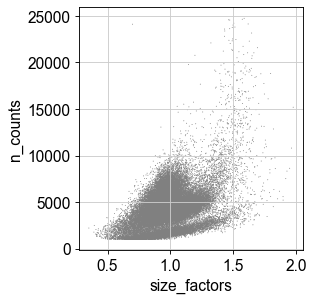

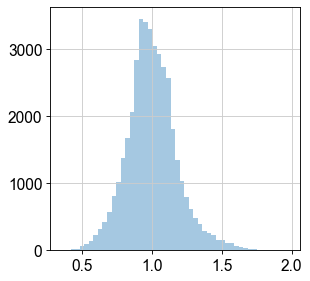

In [14]:
adatas[idx].obs['size_factors'] = size_factors
sc.pl.scatter(adatas[idx], 'size_factors', 'n_counts')
sb.distplot(size_factors, bins=50, kde=False)
pl.show()

Donor 2

In [15]:
idx = 1
input_groups = adatas[idx].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['donor']==donors[idx]].X.T
input_groups.value_counts()  # sometimes merged for small cluster size

0    26780
1    16526
2     9098
3     6518
4     5249
5     4510
6     3175
7      506
Name: groups, dtype: int64

In [16]:
%%R -i data_mat -i input_groups -o size_factors
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

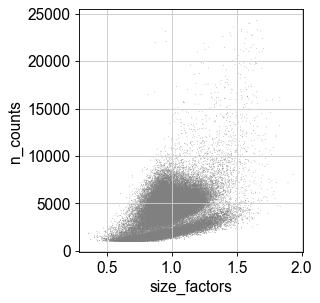

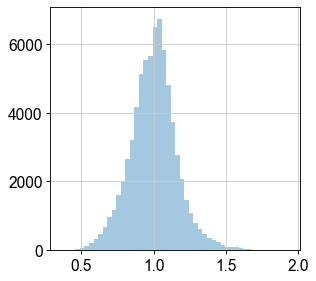

In [17]:
adatas[idx].obs['size_factors'] = size_factors
sc.pl.scatter(adatas[idx], 'size_factors', 'n_counts')
sb.distplot(size_factors, bins=50, kde=False)
pl.show()

Donor 3

In [18]:
idx = 2
input_groups = adatas[idx].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['donor']==donors[idx]].X.T
input_groups.value_counts()  # sometimes merged for small cluster size

0    14463
1     7567
2     5979
3     5084
4     4871
5     2664
6     1062
Name: groups, dtype: int64

In [19]:
%%R -i data_mat -i input_groups -o size_factors
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

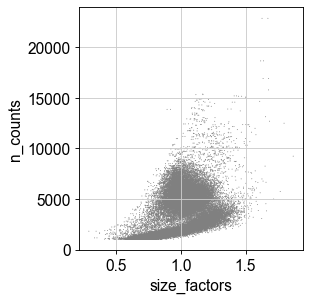

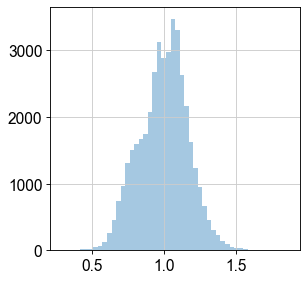

In [20]:
adatas[idx].obs['size_factors'] = size_factors
sc.pl.scatter(adatas[idx], 'size_factors', 'n_counts')
sb.distplot(size_factors, bins=50, kde=False)
pl.show()

Donor 4

In [21]:
idx = 3
input_groups = adatas[idx].obs['groups']
data_mat = adata_tmp[adata_tmp.obs['donor']==donors[idx]].X.T
input_groups.value_counts()  # sometimes merged for small cluster size

0    6722
1    5663
2    4143
3    3004
4    2946
5    2493
6      78
Name: groups, dtype: int64

In [22]:
%%R -i data_mat -i input_groups -o size_factors
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

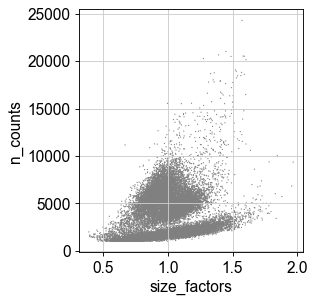

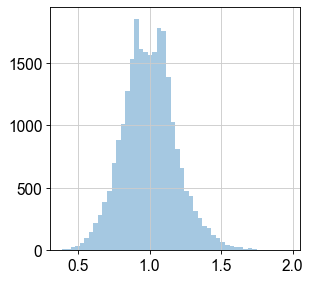

In [23]:
adatas[idx].obs['size_factors'] = size_factors
sc.pl.scatter(adatas[idx], 'size_factors', 'n_counts')
sb.distplot(size_factors, bins=50, kde=False)
pl.show()

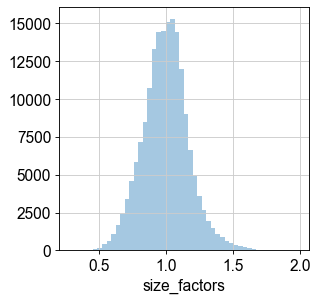

In [24]:
adata_all = adatas[0].concatenate(adatas[1:])
adata_tmp.obs['size_factors'] = adata_all.obs['size_factors'].values
sb.distplot(adata_tmp.obs['size_factors'], bins=50, kde=False)
pl.show()

In [49]:
#adata = sc.read(path_merged)
adata = adata[np.in1d(adata.obs_names, adata_tmp.obs_names)].copy()
adata = adata[:, np.in1d(adata.var_names, adata_tmp.var_names)].copy()

In [52]:
adata.layers['counts'] = adata.X.copy()
adata.obs['size_factors'] = adata_tmp.obs['size_factors']
adata

AnnData object with n_obs × n_vars = 180164 × 20067
    obs: 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'donor', 'n_counts', 'log_counts', 'n_genes', 'mt_fraction', 'size_factors'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts'

In [54]:
adata.X /= adata.obs['size_factors'].values[:, None]
sc.pp.log1p(adata)

And finally, ...

In [56]:
sc.write(adata=adata, filename=path_scran)

In [57]:
# print(adata_tmp.obs)
count_irs = sum([1 for x in adata_tmp.obs['has_ir'] if x=='True'])
print(f'Total Count: {len(adata_tmp.obs)}')
print(f'With IR-Info: {count_irs}')

Total Count: 180164
With IR-Info: 153426


Quick access

In [6]:
adata = sc.read(path_normalized)

In [11]:
adata.obs

,IR_VJ_1_locus,IR_VJ_2_locus,IR_VDJ_1_locus,IR_VDJ_2_locus,IR_VJ_1_cdr3,IR_VJ_2_cdr3,IR_VDJ_1_cdr3,IR_VDJ_2_cdr3,IR_VJ_1_cdr3_nt,IR_VJ_2_cdr3_nt,...,IR_VDJ_1_junction_ins,IR_VDJ_2_junction_ins,has_ir,multi_chain,donor,n_counts,log_counts,n_genes,mt_fraction,size_factors
AAACGGGAGAAGATTC-1-donor_1,TRA,NaN,TRB,NaN,CAMREGSNDMRF,None,CASSIKGPFRTEAFF,None,TGTGCAATGAGAGAGGGCTCGAATGACATGCGCTTT,None,...,None,None,True,False,donor_1,5013.0,3.700098,1872,0.044285,1.186313
AAACGGGTCGGACAAG-1-donor_1,TRA,NaN,TRB,NaN,CAREHMDSNYQLIW,None,CASSQLGRGDNEQFF,None,TGTGCTCGGGAGCACATGGATAGCAACTATCAGTTAATCTGG,None,...,None,None,True,False,donor_1,3827.0,3.582859,1512,0.066632,1.118777
AAAGATGGTACAGACG-1-donor_1,TRA,NaN,TRB,NaN,CAALYNFNKFYF,None,CSARGLTADKDNYEQYF,None,TGTGCCGCGCTCTACAACTTCAACAAATTTTACTTT,None,...,None,None,True,False,donor_1,7092.0,3.850769,1912,0.047800,1.107050
AAAGTAGAGACGCTTT-1-donor_1,TRA,NaN,TRB,NaN,CAVIVWGNNRLAF,None,CASSLDRRLAGQETQYF,None,TGTGCCGTGATCGTGTGGGGGAACAACAGACTCGCTTTT,None,...,None,None,True,False,donor_1,6209.0,3.793022,1740,0.069576,0.970743
AAAGTAGAGCGCTTAT-1-donor_1,TRA,TRA,TRB,NaN,CAGDPDAGNNRKLIW,CALTPFNDYKLSF,CAISEATDTQYF,None,TGTGCAGGCGACCCCGATGCTGGCAACAACCGTAAGCTGATTTGG,TGTGCTCTGACTCCCTTTAACGACTACAAGCTCAGCTTT,...,None,None,True,False,donor_1,5800.0,3.763428,1698,0.049828,1.023144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATCAGTAC-8-donor_4,TRA,NaN,TRB,NaN,CIPPAQGGSEKLVF,None,CASSETTGTFNYEQFF,None,TGCATCCCACCCGCTCAGGGCGGATCTGAAAAGCTGGTCTTT,None,...,None,None,True,False,donor_4,5657.0,3.752586,1503,0.066643,0.881108
TTTGTCAGTCTAAACC-8-donor_4,TRA,NaN,TRB,NaN,CAMRGLEGGGNKLTF,None,CASSQDRGFGETQYF,None,TGTGCAATGAGAGGGCTAGAGGGAGGAGGAAACAAACTCACCTTT,None,...,None,None,True,False,donor_4,6796.0,3.832253,1816,0.056945,0.961030
TTTGTCAGTCTCTCGT-8-donor_4,TRA,NaN,TRB,NaN,CILRDGKGGGSQGNLIF,None,CASSSREPRELFF,None,TGCATCCTGAGAGACGGGAAGGGCGGAGGAAGCCAAGGAAATCTCA...,None,...,None,None,True,False,donor_4,2933.0,3.467312,978,0.055234,0.703113
TTTGTCATCCCACTTG-8-donor_4,TRA,NaN,TRB,NaN,CAVRDLMDTGRRALTF,None,CSATGQETQYF,None,TGTGCTGTGAGAGACCTCATGGACACGGGCAGGAGAGCACTTACTTTT,None,...,None,None,True,False,donor_4,5401.0,3.732474,1564,0.046288,0.907895
